In [1]:
import numpy as np
import torch
import pandas as pd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline 

In [3]:
kaggle_train = pd.read_csv('C:/datasets/digit-recognizer/train.csv').drop('label',axis=1).values
kaggle_labels = pd.read_csv('C:/datasets/digit-recognizer/train.csv')['label'].values

In [4]:
# not normalized images (0-255 pixels)
kaggle_train.dtype

dtype('int64')

In [5]:
kaggle_labels.dtype

dtype('int64')

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
kaggle_train = scaler.fit_transform(kaggle_train)

In [7]:
kaggle_train = torch.tensor(kaggle_train, dtype=torch.float32).view(42000,1,28,28)

In [8]:
kaggle_labels = torch.tensor(kaggle_labels, dtype=torch.int64)

In [9]:
kaggle_train.dtype, kaggle_labels.dtype

(torch.float32, torch.int64)

In [10]:
def normalize_dataset(image_dataset):
    if str(image_dataset.dtype)[:5] == 'torch' and len(image_dataset.shape) == 4:
        for i in range(image_dataset.shape[0]):
            new = image_dataset[i][0].flatten()
            new = 2*(new/255)-1
            image_dataset[i][0] = new.view(28,28) 
        return image_dataset
    else:
        raise Exception("IMAGE DATASET DOES NOT MEET REQUIREMENTS")

In [11]:
# kaggle_train = normalize_dataset(kaggle_train)

In [12]:
class KaggleDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.x_train = features
        self.y_train = labels
        
    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]


In [13]:
from torchvision import datasets, transforms

train_transforms = transforms.Compose([transforms.RandomRotation(15), 
                                       transforms.ToTensor()
#                                         transforms.Normalize(0.5,0.5)
                                       ]) 
# transforms.RandomRotation(20),
# transforms.CenterCrop(28),

transform = transforms.Compose([
                                    transforms.ToTensor()
#                                  transforms.Normalize(0.5,0.5)
                               ])

kaggle_train = KaggleDataset(kaggle_train, kaggle_labels)

train = datasets.MNIST(root='data', train=True,
                                   download=True, transform=train_transforms)
train_valid = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

test = datasets.MNIST(root='data', train=False,
                                  download=True, transform=train_transforms)

test_valid = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [14]:
from torch.utils.data.sampler import SubsetRandomSampler

valid_size = 0.060952381

# obtain training indices that will be used for validation
num_kaggle_train = len(kaggle_train)
indices = list(range(num_kaggle_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_kaggle_train))
kaggle_train_idx, kaggle_train_valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
kaggle_train_sampler = SubsetRandomSampler(kaggle_train_idx)
kaggle_train_valid_sampler = SubsetRandomSampler(kaggle_train_valid_idx)

kaggle_train_loader = torch.utils.data.DataLoader(kaggle_train, batch_size=64,
    sampler=kaggle_train_sampler, num_workers=0)
kaggle_train_valid_loader = torch.utils.data.DataLoader(kaggle_train, batch_size=64, 
    sampler=kaggle_train_valid_sampler, num_workers=0)

In [15]:
valid_size = 0.064

# obtain training indices that will be used for validation
num_train = len(train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, train_valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
train_valid_sampler = SubsetRandomSampler(train_valid_idx)

train_loader = torch.utils.data.DataLoader(train, batch_size=64,
    sampler=train_sampler, num_workers=0)
train_valid_loader = torch.utils.data.DataLoader(train_valid, batch_size=64, 
    sampler=train_valid_sampler, num_workers=0)

In [16]:
valid_size = 0.128

# obtain training indices that will be used for validation
num_test = len(test)
indices = list(range(num_test))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_test))
test_idx, test_valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
test_sampler = SubsetRandomSampler(test_idx)
test_valid_sampler = SubsetRandomSampler(test_valid_idx)

test_loader = torch.utils.data.DataLoader(test, batch_size=64,
    sampler=test_sampler, num_workers=0)
test_valid_loader = torch.utils.data.DataLoader(test_valid, batch_size=64, 
    sampler=test_valid_sampler, num_workers=0)

In [17]:
# for training
len(kaggle_train_loader.sampler), len(train_loader.sampler), len(test_loader.sampler)

(39440, 56160, 8720)

In [18]:
# for validation
len(kaggle_train_valid_loader.sampler), len(train_valid_loader.sampler), len(test_valid_loader.sampler)

(2560, 3840, 1280)

In [19]:
iter1 = iter(kaggle_train_loader)
iter2 = iter(train_loader)
iter3 = iter(test_loader)

In [20]:
img1, lbl1 = next(iter1)

In [21]:
lbl1.to(torch.int64)

tensor([1, 9, 3, 9, 4, 3, 0, 1, 6, 6, 2, 0, 1, 0, 0, 7, 1, 2, 8, 7, 9, 4, 0, 1,
        1, 4, 1, 0, 2, 0, 2, 2, 8, 3, 6, 8, 2, 8, 5, 0, 3, 9, 7, 4, 3, 2, 2, 1,
        0, 9, 8, 9, 5, 5, 3, 4, 7, 3, 2, 8, 1, 7, 3, 8])

In [22]:
img2, lbl2 = next(iter2)

In [23]:
lbl2

tensor([2, 3, 1, 9, 3, 6, 9, 1, 5, 2, 4, 1, 1, 1, 6, 9, 2, 2, 5, 3, 7, 9, 7, 9,
        3, 6, 4, 8, 6, 1, 1, 0, 4, 2, 6, 3, 4, 3, 7, 7, 8, 7, 2, 0, 7, 2, 9, 5,
        2, 2, 4, 2, 1, 1, 6, 9, 5, 1, 3, 1, 6, 9, 5, 3])

In [24]:
img3, lbl3 = next(iter3)

In [25]:
lbl3

tensor([1, 9, 0, 3, 9, 5, 0, 2, 0, 6, 5, 9, 3, 6, 3, 3, 1, 1, 4, 3, 6, 5, 7, 9,
        2, 3, 1, 3, 8, 2, 7, 3, 2, 7, 9, 0, 3, 8, 4, 5, 9, 6, 1, 5, 6, 2, 1, 2,
        8, 3, 7, 3, 0, 2, 8, 5, 0, 1, 9, 6, 3, 2, 8, 0])

In [26]:
img1[0].flatten().min(), img1[0].flatten().mean(), img1[0].flatten().max(), img1[0].flatten().std() 

(tensor(0.), tensor(0.0676), tensor(1.), tensor(0.2293))

<AxesSubplot:ylabel='Count'>

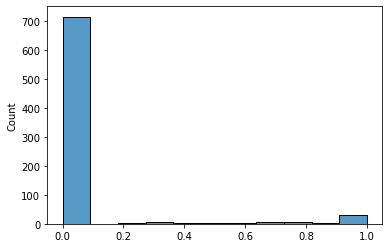

In [27]:
sns.histplot(img1[0].flatten())

In [28]:
img2[0].flatten().min(), img2[0].flatten().mean(), img2[0].flatten().max(), img2[0].flatten().std() 

(tensor(0.), tensor(0.1723), tensor(1.), tensor(0.3543))

<AxesSubplot:ylabel='Count'>

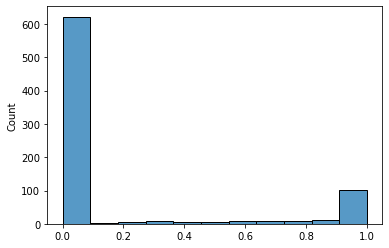

In [29]:
sns.histplot(img2[0].flatten())

In [30]:
img3[0].flatten().min(), img3[0].flatten().mean(), img3[0].flatten().max(), img3[0].flatten().std() 

(tensor(0.), tensor(0.1245), tensor(1.), tensor(0.3124))

<AxesSubplot:ylabel='Count'>

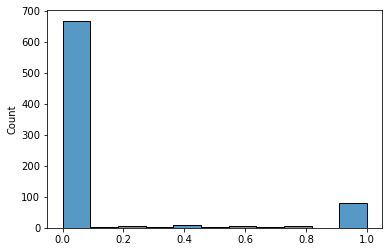

In [31]:
sns.histplot(img3[0].flatten())

In [32]:
mean_mean_of_batch = []
mean_std_of_batch = []
for i in range(img1.shape[0]):
    mean_mean_of_batch.append(img1[i][0].mean())
    mean_std_of_batch.append(img1[i][0].std())
    if i < 5:
        print(img1[i][0].min(), img1[i][0].mean(), img1[i][0].max(), img1[i][0].std())
print("============================")
print(f"mean_mean_of_batch: {np.array(mean_mean_of_batch).mean()}, mean_std_of_batch: {np.array(mean_std_of_batch).mean()}")

tensor(0.) tensor(0.0676) tensor(1.) tensor(0.2293)
tensor(0.) tensor(0.1769) tensor(1.) tensor(0.3550)
tensor(0.) tensor(0.1471) tensor(1.) tensor(0.3220)
tensor(0.) tensor(0.1228) tensor(1.) tensor(0.2938)
tensor(0.) tensor(0.1113) tensor(1.) tensor(0.2859)
mean_mean_of_batch: 0.13264235854148865, mean_std_of_batch: 0.30367863178253174


In [33]:
mean_mean_of_batch = []
mean_std_of_batch = []
for i in range(img2.shape[0]):
    mean_mean_of_batch.append(img2[i][0].mean())
    mean_std_of_batch.append(img2[i][0].std())
    if i < 5:
        print(img2[i][0].min(), img2[i][0].mean(), img2[i][0].max(), img2[i][0].std())
print("============================")
print(f"mean_mean_of_batch: {np.array(mean_mean_of_batch).mean()}, mean_std_of_batch: {np.array(mean_std_of_batch).mean()}")

tensor(0.) tensor(0.1723) tensor(1.) tensor(0.3543)
tensor(0.) tensor(0.1632) tensor(1.) tensor(0.3396)
tensor(0.) tensor(0.0899) tensor(1.) tensor(0.2708)
tensor(0.) tensor(0.0998) tensor(1.) tensor(0.2672)
tensor(0.) tensor(0.1518) tensor(1.) tensor(0.3325)
mean_mean_of_batch: 0.12863576412200928, mean_std_of_batch: 0.2995503842830658


In [34]:
mean_mean_of_batch = []
mean_std_of_batch = []
for i in range(img3.shape[0]):
    mean_mean_of_batch.append(img3[i][0].mean())
    mean_std_of_batch.append(img3[i][0].std())
    if i < 5:
        print(img3[i][0].min(), img3[i][0].mean(), img3[i][0].max(), img3[i][0].std())
print("============================")
print(f"mean_mean_of_batch: {np.array(mean_mean_of_batch).mean()}, mean_std_of_batch: {np.array(mean_std_of_batch).mean()}")

tensor(0.) tensor(0.1245) tensor(1.) tensor(0.3124)
tensor(0.) tensor(0.1447) tensor(1.) tensor(0.3287)
tensor(0.) tensor(0.1506) tensor(1.) tensor(0.3248)
tensor(0.) tensor(0.1848) tensor(1.) tensor(0.3617)
tensor(0.) tensor(0.0948) tensor(1.) tensor(0.2688)
mean_mean_of_batch: 0.13368050754070282, mean_std_of_batch: 0.30511733889579773


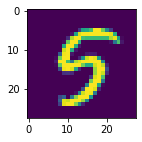

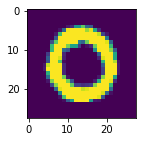

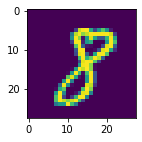

In [35]:
# show 3 random images of data set
for i in (np.random.rand(3)*100).astype('int'):
    plt.figure(figsize=(2, 2))
    plt.imshow(kaggle_train_loader.dataset.x_train[i].squeeze(), interpolation='nearest')
    plt.show()

In [36]:
import torch.nn as nn
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 20, 2, padding=1)
        self.norm1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 40, 2, padding=1)
        self.norm2 = nn.BatchNorm2d(40)
        
        self.conv3 = nn.Conv2d(40, 60, 2, padding=1)
        self.norm3 = nn.BatchNorm2d(60)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(60 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = x.view(x.shape[0],1,28,28)
        
        x = self.norm1(self.pool(F.relu(self.conv1(x))))
        
        x = self.dropout(x)
        
        x = self.norm2(self.pool(F.relu(self.conv2(x))))
        
        x = self.dropout(x)
        
        x = self.norm3(self.pool(F.relu(self.conv3(x))))
        

        x = self.dropout(x)

        # flatten image input
        x = x.view(-1, 60 * 4 * 4)

        x = F.relu(self.fc1(x))

        x = self.dropout(x)

        x = F.relu(self.fc2(x))

        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))

        x = self.dropout(x)

        x = F.log_softmax(self.fc4(x), dim=1)

        return x

# create a complete CNN
model = Net().to(device)
print(model)


Net(
  (conv1): Conv2d(1, 20, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 60, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=960, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [37]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [38]:
# initialize lists to monitor test loss and accuracy
valid_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for training

for data, target in kaggle_train_valid_loader:
    target = torch.tensor(np.array(target)).to(torch.int64)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.to(device))
    # calculate the loss
    loss = criterion(output, target.to(device))
    # update test loss 
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(64):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
valid_loss = valid_loss/len(kaggle_train_valid_loader.sampler)
print('Kaggle train Loss: {:.6f}\n'.format(valid_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Kaggle train Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Kaggle train Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nKaggle train (Overall): %0d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
print('======================================')

############################################################################################################
############################################################################################################
############################################################################################################
############################################################################################################

# initialize lists to monitor test loss and accuracy
valid_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for training

for data, target in train_valid_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.to(device))
    # calculate the loss
    loss = criterion(output, target.to(device))
    # update test loss 
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(64):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
valid_loss = valid_loss/len(train_valid_loader.sampler)
print('Test Loss: {:.6f}\n'.format(valid_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Train Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Train Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTrain Accuracy (Overall): %0d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

print('=====================================')

############################################################################################################
############################################################################################################
############################################################################################################
############################################################################################################


# initialize lists to monitor test loss and accuracy
valid_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for training

for data, target in test_valid_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.to(device))
    # calculate the loss
    loss = criterion(output, target.to(device))
    # update test loss 
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(64):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
valid_loss = valid_loss/len(test_valid_loader.sampler)
print('Test Loss: {:.6f}\n'.format(valid_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %0d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Kaggle train Loss: 2.304414

Kaggle train Accuracy of     0:  0% ( 0/284)
Kaggle train Accuracy of     1:  0% ( 0/275)
Kaggle train Accuracy of     2:  0% ( 0/254)
Kaggle train Accuracy of     3:  0% ( 0/254)
Kaggle train Accuracy of     4:  0% ( 0/242)
Kaggle train Accuracy of     5: 100% (239/239)
Kaggle train Accuracy of     6:  0% ( 0/258)
Kaggle train Accuracy of     7:  0% ( 0/270)
Kaggle train Accuracy of     8:  0% ( 0/219)
Kaggle train Accuracy of     9:  0% ( 0/265)

Kaggle train (Overall): 9% (239/2560)
Test Loss: 2.303120

Train Accuracy of     0:  0% ( 0/376)
Train Accuracy of     1:  0% ( 0/447)
Train Accuracy of     2:  0% ( 0/365)
Train Accuracy of     3:  0% ( 0/371)
Train Accuracy of     4:  0% ( 0/377)
Train Accuracy of     5: 100% (365/365)
Train Accuracy of     6:  0% ( 0/388)
Train Accuracy of     7:  0% ( 0/387)
Train Accuracy of     8:  0% ( 0/378)
Train Accuracy of     9:  0% ( 0/386)

Train Accuracy (Overall): 9% (365/3840)
Test Loss: 2.305053

Test Accuracy o

In [ ]:
# TRAINING
# batch_size is 70, so number of batches is 600
# loop for 1 epoch
epochs = 50
accuracy_min = 0.997135

for e in range(epochs):
    print(f"Epoch number {e+1}")
    model.train()
    train_loss = 0
    kaggle_train_loss = 0
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    
    for data, target in kaggle_train_loader:
        target = torch.tensor(np.array(target)).to(torch.int64)
        X_batch = data.to(device)
        y_batch = target.to(device)
        optimizer.zero_grad()
        loss = criterion(model(X_batch), y_batch)
        loss.backward()
        optimizer.step()
        kaggle_train_loss += loss.item()

    for data, target in train_loader:
        target = torch.tensor(np.array(target)).to(torch.int64)
        X_batch = data.to(device)
        y_batch = torch.tensor(np.array(target)).to(torch.int64).to(device)
        optimizer.zero_grad()
        loss = criterion(model(X_batch), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    for data, target in test_loader:
        target = torch.tensor(np.array(target)).to(torch.int64)
        X_batch = data.to(device)
        y_batch = target.to(device)
        optimizer.zero_grad()
        loss = criterion(model(X_batch), y_batch)
        loss.backward()
        optimizer.step()
        test_loss += loss.item()
    
    # VALIDATION
    model.eval()    
    for data, target in kaggle_train_valid_loader:
        target = torch.tensor(np.array(target)).to(torch.int64)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.to(device))
        # calculate the loss
        loss = criterion(output, target.to(device))
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
    for data, target in train_valid_loader:
        target = torch.tensor(np.array(target)).to(torch.int64)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.to(device))
        # calculate the loss
        loss = criterion(output, target.to(device))
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    
    for data, target in test_valid_loader:
        target = torch.tensor(np.array(target)).to(torch.int64)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.to(device))
        # calculate the loss
        loss = criterion(output, target.to(device))
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
    accuracy = np.sum(class_correct) / np.sum(class_total)
    print(f"train_loss: {kaggle_train_loss/len(kaggle_train_loader.sampler)}, train_loss: {train_loss/len(train_loader.sampler)}, train_loss: {test_loss/len(test_loader.sampler)}, accuracy on valid_set: {accuracy.item()}")
    if accuracy >= accuracy_min:
        print('Accuracy metrics increased ({:.6f} --> {:.6f}).  Saving model ...'.format(accuracy_min,accuracy))
        torch.save(model.state_dict(), 'MNIST-CNN.pt')
        accuracy_min = accuracy
    print("=========================================")
    

In [39]:
model.load_state_dict(torch.load('MNIST-CNN.pt'))

<All keys matched successfully>

In [40]:
# initialize lists to monitor test loss and accuracy
valid_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for training

for data, target in kaggle_train_valid_loader:
    target = torch.tensor(np.array(target)).to(torch.int64)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.to(device))
    # calculate the loss
    loss = criterion(output, target.to(device))
    # update test loss 
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(64):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
valid_loss = valid_loss/len(kaggle_train_valid_loader.sampler)
print('Kaggle train Loss: {:.6f}\n'.format(valid_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Kaggle train Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Kaggle train Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nKaggle train (Overall): %0d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
print('======================================')

############################################################################################################
############################################################################################################
############################################################################################################
############################################################################################################

# initialize lists to monitor test loss and accuracy
valid_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for training

for data, target in train_valid_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.to(device))
    # calculate the loss
    loss = criterion(output, target.to(device))
    # update test loss 
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(64):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
valid_loss = valid_loss/len(train_valid_loader.sampler)
print('Test Loss: {:.6f}\n'.format(valid_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Train Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Train Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTrain Accuracy (Overall): %0d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

print('=====================================')

############################################################################################################
############################################################################################################
############################################################################################################
############################################################################################################


# initialize lists to monitor test loss and accuracy
valid_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for training

for data, target in test_valid_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.to(device))
    # calculate the loss
    loss = criterion(output, target.to(device))
    # update test loss 
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(64):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
valid_loss = valid_loss/len(test_valid_loader.sampler)
print('Test Loss: {:.6f}\n'.format(valid_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %0d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Kaggle train Loss: 0.004343

Kaggle train Accuracy of     0: 100% (284/284)
Kaggle train Accuracy of     1: 100% (275/275)
Kaggle train Accuracy of     2: 100% (254/254)
Kaggle train Accuracy of     3: 100% (254/254)
Kaggle train Accuracy of     4: 100% (242/242)
Kaggle train Accuracy of     5: 99% (238/239)
Kaggle train Accuracy of     6: 100% (258/258)
Kaggle train Accuracy of     7: 100% (270/270)
Kaggle train Accuracy of     8: 100% (219/219)
Kaggle train Accuracy of     9: 99% (264/265)

Kaggle train (Overall): 99% (2558/2560)
Test Loss: 0.005454

Train Accuracy of     0: 100% (376/376)
Train Accuracy of     1: 99% (446/447)
Train Accuracy of     2: 99% (364/365)
Train Accuracy of     3: 99% (369/371)
Train Accuracy of     4: 100% (377/377)
Train Accuracy of     5: 99% (364/365)
Train Accuracy of     6: 99% (387/388)
Train Accuracy of     7: 100% (387/387)
Train Accuracy of     8: 99% (377/378)
Train Accuracy of     9: 99% (384/386)

Train Accuracy (Overall): 99% (3831/3840)
Test 

In [64]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
#     if version == "MNIST":
#         ax2.set_yticklabels(np.arange(10))
#     elif version == "Fashion":
#         ax2.set_yticklabels(['T-shirt/top',
#                             'Trouser',
#                             'Pullover',
#                             'Dress',
#                             'Coat',
#                             'Sandal',
#                             'Shirt',
#                             'Sneaker',
#                             'Bag',
#                             'Ankle Boot'], size='small');
#     ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Predicted Digit = 1


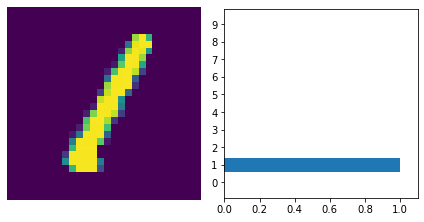

In [71]:
images, labels = next(iter1)

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img.cuda())

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps).cpu()
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [42]:
submission = pd.read_csv('C:/datasets/digit-recognizer/test.csv').values; submission.shape

(28000, 784)

In [43]:
submission = scaler.transform(submission)

In [44]:
submission = torch.tensor(submission, dtype=torch.float32).view(28000,1,28,28)

In [45]:
submission.shape

torch.Size([28000, 1, 28, 28])

In [53]:
values1, preds1 = torch.topk(model(submission[:7000].to(device)), 1)
# preds1 = pd.DataFrame(preds1.cpu()).rename(columns={0:'output'})
# preds1.to_csv('C:/datasets/digit-recognizer/outputs/preds1.csv'); preds1

,output
0,2
1,0
2,9
3,0
4,3
...,...
6995,2
6996,0
6997,4
6998,4


In [54]:
values2, preds2 = torch.topk(model(submission[7000:14000].to(device)), 1)
# preds2 = pd.DataFrame(preds2.cpu()).rename(columns={0:'output'})
# preds2.to_csv('C:/datasets/digit-recognizer/outputs/preds2.csv'); preds2

,output
0,8
1,1
2,7
3,6
4,5
...,...
6995,9
6996,3
6997,5
6998,4


In [87]:
values3, preds3 = torch.topk(model(submission[14000:21000].to(device)), 1)
# preds3 = pd.DataFrame(preds3.cpu()).rename(columns={0:'output'})
# preds3.to_csv('C:/datasets/digit-recognizer/outputs/preds3.csv'); preds3

,output
0,3
1,4
2,3
3,6
4,7
...,...
6995,6
6996,1
6997,4
6998,2


In [88]:
values4, preds4 = torch.topk(model(submission[21000:28000].to(device)), 1)
# preds4 = pd.DataFrame(preds4.cpu()).rename(columns={0:'output'})
# preds4.to_csv('C:/datasets/digit-recognizer/outputs/preds4.csv'); preds4

,output
0,7
1,5
2,5
3,4
4,2
...,...
6995,9
6996,7
6997,3
6998,9


In [48]:
preds1 = pd.read_csv('C:/datasets/digit-recognizer/outputs/preds1.csv').drop('Unnamed: 0',axis=1); 
preds2 = pd.read_csv('C:/datasets/digit-recognizer/outputs/preds2.csv').drop('Unnamed: 0',axis=1); 
preds3 = pd.read_csv('C:/datasets/digit-recognizer/outputs/preds3.csv').drop('Unnamed: 0',axis=1); 
preds4 = pd.read_csv('C:/datasets/digit-recognizer/outputs/preds4.csv').drop('Unnamed: 0',axis=1); 

In [53]:
df1 = pd.concat([preds1['output'], preds2['output']], axis=0); df1

0       2
1       0
2       9
3       0
4       3
       ..
6995    9
6996    3
6997    5
6998    4
6999    0
Name: output, Length: 14000, dtype: int64

In [54]:
df2 = pd.concat([preds3['output'], preds4['output']], axis=0); df2

0       3
1       4
2       3
3       6
4       7
       ..
6995    9
6996    7
6997    3
6998    9
6999    2
Name: output, Length: 14000, dtype: int64

In [ ]:
df = pd.concat([df1, df2], axis=0); df

In [62]:
df = df.reset_index().drop('index', axis=1); df

,output
0,2
1,0
2,9
3,0
4,3
...,...
27995,9
27996,7
27997,3
27998,9


In [63]:
sub = pd.read_csv('C:/datasets/digit-recognizer/sample_submission.csv'); sub

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [64]:
sub['Label'] = df['output']

In [65]:
sub.to_csv('C:/datasets/digit-recognizer/sub_results.csv', index=False)

In [66]:
pd.read_csv('C:/datasets/digit-recognizer/sub_results.csv')

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
